In [44]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures

In [45]:
df = pd.read_csv("ex2data2.txt", names=['test1', 'test2', 'status'])
df.head()

,test1,test2,status
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


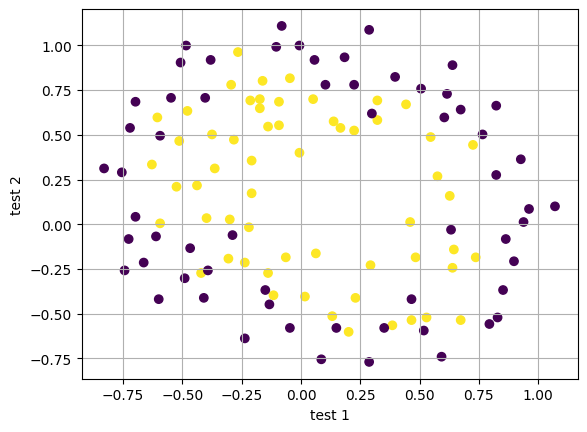

In [46]:
plt.scatter(df['test1'], df['test2'], c = df['status'])
plt.xlabel('test 1')
plt.ylabel('test 2')
plt.grid(True)

In [47]:
x = df[['test1', 'test2']].values

def normalize(x):
  std_fixed = np.zeros_like(np.std(x, axis=0))
  std_fixed[np.std(x, axis=0) == 0] = 1
  std_fixed += np.std(x, axis=0)
  return (x - np.mean(x, axis=0))/std_fixed, np.mean(x, axis=0), np.std(x, axis=0)

poly = PolynomialFeatures(30)
x = poly.fit_transform(x)
x[:,1:], mean, std = normalize(x[:,1:])
mean = np.insert(mean, 0, 0)
std = np.insert(std, 0, 1)

y = df['status'].values
y = y.reshape((-1, 1))

In [48]:
def g(z):
    return 1/(1 + np.exp(-z))
def h(theta, x):
    return g(x.dot(theta))
def loss_func(theta, x, y):
    return (-1/y.size *(y.T.dot(np.log(h(theta, x))) + (1-y).T.dot(np.log(1-h(theta,x))))).mean()

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, train_size=0.8, shuffle=True, random_state=42)

In [50]:
def loss_func_reg(theta, x, y, l):
    return loss_func(theta, x, y) + l/(2*y.size)*(theta[1:]**2).sum()

In [51]:
def grad_desc(loss_func_reg, theta, x, y, a, l, iterations = 100000):
    m = y.size
    loss_values = []

    for _ in range(iterations): 
        last_l = loss_func(theta, x, y)
        loss_values.append(last_l) 
        
        h = g(x.dot(theta))
        gradient = x.T.dot(h - y)/m
        theta[0] -= a*gradient[0]
        theta[1:] = theta[1:]*(1-l*a/m) - a*gradient[1:]

    return theta, loss_values

In [52]:
theta = np.zeros((x_train.shape[1], 1))
theta, loss_values = grad_desc(loss_func_reg, theta, x_train, y_train, 0.5, 0)
theta_reg = np.zeros((x_train.shape[1], 1))
theta_reg, loss_values_reg = grad_desc(loss_func_reg, theta_reg, x_train, y_train, 0.5, 1)

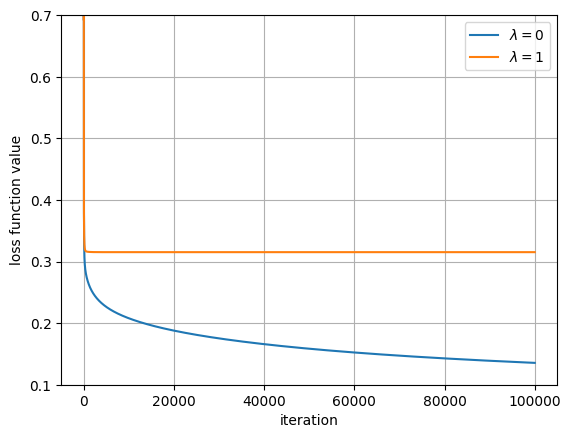

In [53]:
plt.plot(range(len(loss_values)), loss_values, label='$\lambda=0$')
plt.plot(range(len(loss_values_reg)), loss_values_reg, label='$\lambda=1$')
plt.ylim(0.1, 0.7)
plt.xlabel("iteration")
plt.ylabel("loss function value")
plt.grid(True)
plt.legend()

In [54]:
def accuracy(theta, x, h, y):
    temp = 0
    for i in range(y.size):
        if h(theta, x[i]).mean().round() ==  y[i]:
            temp += 1
    return temp/y.size

In [55]:
print(f'Точность без регуляризации на тренировочной выборке составляет {accuracy(theta, x_train, h, y_train)*100 :.2f}%')
print(f'Точность с регуляризацией на тренировочной выборке составляет {accuracy(theta_reg, x_train, h, y_train)*100 :.2f}%')
print(f'Точность без регуляризации на тестовой выборке составляет {accuracy(theta, x_test, h, y_test)*100 :.2f}%')
print(f'Точность с регуляризацией на тестовой выборке составляет {accuracy(theta_reg, x_test, h, y_test)*100 :.2f}%')

Точность без регуляризации на тренировочной выборке составляет 94.68%
Точность с регуляризацией на тренировочной выборке составляет 85.11%
Точность без регуляризации на тестовой выборке составляет 70.83%
Точность с регуляризацией на тестовой выборке составляет 79.17%


In [56]:
x1 = np.linspace(-1, 1.25, 500)
x2 = np.linspace(-1, 1.25, 500)
X1, X2 = np.meshgrid(x1, x2)

X_poly = poly.fit_transform(np.c_[X1.ravel(), X2.ravel()])
X_poly[:,:]= (X_poly[:,:] - mean)/std

Z = h(theta, X_poly)
Z = Z.reshape(X1.shape)
Z[Z > 0.5] = 1
Z[Z <= 0.5] = 0
Z_reg = h(theta_reg, X_poly)
Z_reg = Z_reg.reshape(X1.shape)
Z_reg[Z_reg > 0.5] = 1
Z_reg[Z_reg <= 0.5] = 0


/tmp/ipykernel_196717/3886835342.py:2: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))


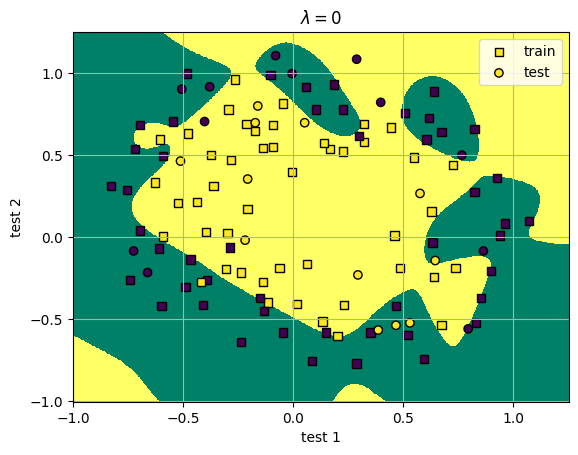

In [57]:
plt.pcolormesh(X1, X2, Z, cmap='summer')
X = np.copy(x_train)
X[:,:] = X[:,:] * std + mean
plt.scatter(X[:,1], X[:,2], c = y_train, edgecolors='black', marker='s', label='train')
X = np.copy(x_test)
X[:,:] = X[:,:] * std + mean
plt.scatter(X[:,1], X[:,2], c = y_test, edgecolors='black', marker='o', label='test')
plt.xlabel('test 1')
plt.ylabel('test 2')
plt.title('$\lambda = 0$')
plt.legend()
plt.grid(True)

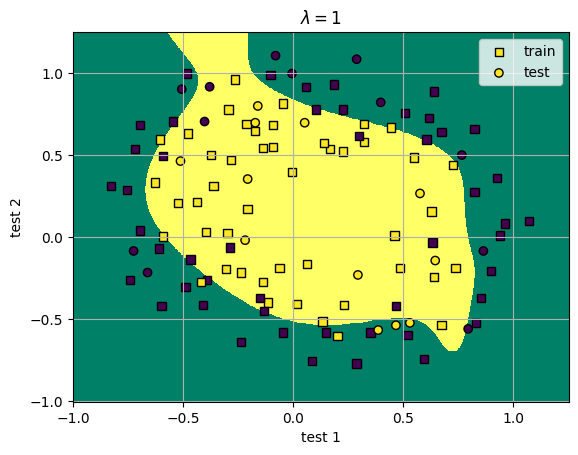

In [58]:
plt.pcolormesh(X1, X2, Z_reg, cmap='summer')
X = np.copy(x_train)
X[:,:] = X[:,:] * std + mean
plt.scatter(X[:,1], X[:,2], c = y_train, edgecolors='black', marker='s', label='train')
X = np.copy(x_test)
X[:,:] = X[:,:] * std + mean
plt.scatter(X[:,1], X[:,2], c = y_test, edgecolors='black', marker='o', label='test')
plt.xlabel('test 1')
plt.ylabel('test 2')
plt.title('$\lambda = 1$')
plt.legend()
plt.grid(True)
